In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda:0')

torch.manual_seed(121)

In [ ]:
class PIRBN(nn.Module):

    def __init__(self, centers, b_init=1.0, dtype=torch.float64):
        super().__init__()
        self.dtype = dtype
        
        self.register_buffer('centers', centers.to(dtype))
        self.N = centers.shape[0]
        
        self.b = nn.Parameter(b_init * torch.ones(1, self.N, dtype=dtype)) 
        self.a = nn.Parameter(torch.randn(self.N, 1, dtype=dtype))          

    def forward(self, x):

        x_exp = x.unsqueeze(1)           
        c_exp = self.centers.unsqueeze(0) 
        
        
        dist_sq = torch.sum((x_exp - c_exp)**2, dim=2)
        
        
        rbf = torch.exp(-self.b**2 * dist_sq)  
        
        
        u = torch.matmul(rbf, self.a)
        return u

    def uxy(model, xy):
        xy.requires_grad_(True)
        u = model(xy)
        grads = torch.autograd.grad(
            u, xy, grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]          # shape (N,2)
        ux  = grads[:, 0:1]
        uy  = grads[:, 1:2]
        uxx = torch.autograd.grad(
            ux, xy, grad_outputs=torch.ones_like(ux),
            create_graph=True
        )[0][:, 0:1]
        uyy = torch.autograd.grad(
            uy, xy, grad_outputs=torch.ones_like(uy),
            create_graph=True
        )[0][:, 1:1+1]

        return u, uxx, uyy


In [ ]:
# Parameters
a1 = 1
a2 = 8
c2 = 1.0  

def analytical(x, y):
    p = torch.pi
    s1 = torch.sin(a1 * p * x)
    s2 = torch.sin(a2 * p * y)
    return s1 * s2

def right_side(x, y):
    p = torch.pi
    s1 = torch.sin(a1 * p * x)
    s2 = torch.sin(a2 * p * y)
    return (c2 - (a1**2 + a2**2) * p**2) * s1 * s2


In [ ]:
Nx = 64
Ny = 64
xcenters = torch.linspace(-1.2, 1.2, Nx, dtype=torch.float64)
ycenters = torch.linspace(-1.2, 1.2, Ny, dtype=torch.float64)
Xc, Yc = torch.meshgrid(xcenters, ycenters, indexing='ij')
centers = torch.stack([Xc.flatten(), Yc.flatten()], dim=1)  # (Nx*Ny, 2)

Ncolloc = 10000
xcolloc = 2.0 * torch.rand(Ncolloc, 1, dtype=torch.float64) - 1.0
ycolloc = 2.0 * torch.rand(Ncolloc, 1, dtype=torch.float64) - 1.0
xycolloc = torch.cat([xcolloc, ycolloc], dim=1).to(device)

Nbc = 2000
y_bc1 = 2.0 * torch.rand(Nbc // 2, 1, dtype=torch.float64) - 1.0
x_bc1 = torch.full_like(y_bc1, -1.0)
x_bc2 = torch.full_like(y_bc1,  1.0)
xy_bc_lr = torch.cat([
    torch.cat([x_bc1, y_bc1], dim=1),
    torch.cat([x_bc2, y_bc1], dim=1)
], dim=0)

x_bc3 = 2.0 * torch.rand(Nbc // 2, 1, dtype=torch.float64) - 1.0
y_bc3 = torch.full_like(x_bc3, -1.0)
y_bc4 = torch.full_like(x_bc3,  1.0)
xy_bc_tb = torch.cat([
    torch.cat([x_bc3, y_bc3], dim=1),
    torch.cat([x_bc3, y_bc4], dim=1)
], dim=0)

xybc = torch.cat([xy_bc_lr, xy_bc_tb], dim=0).to(device)


In [ ]:
model = PIRBN(centers, b_init=5.0, dtype=torch.float64).to(device)

print(f"PIRBN has {sum(p.numel() for p in model.parameters()):,} parameters")


PIRBN has 8,193 parameters


In [ ]:
# Training

optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-2)

optimizer2 = torch.optim.LBFGS(model.parameters(), 
                             lr=1.0,
                             max_iter=10**8,
                             max_eval=10**8,
                             tolerance_grad=1e-08,
                             tolerance_change=1e-08,
                             history_size=50,
                             line_search_fn=None)


epochs = 3*10**3
print_interval = 500

x_validate = 2 * torch.rand(1000, 1, dtype=torch.float64, device=device) - 1.0
t_validate = torch.rand(1000, 1, dtype=torch.float64, device=device)
xt_validate = torch.cat([x_validate, t_validate], dim=1)



def loss_print(pde_loss, bc_loss, model, epoch):
    with torch.no_grad():           
        u_pred_validate = model(xt_validate)
        u_exact_validate = analytical(x_validate, t_validate)
        l2_error = torch.sqrt(torch.mean((u_pred_validate - u_exact_validate)**2)) / \
                    torch.sqrt(torch.mean(u_exact_validate**2))
    
    print(f"\n Epoch {epoch:6d} | "
            f"PDE: {pde_loss.item():.2e} | BC: {bc_loss.item():.2e} | "
            f"L2_rel: {l2_error.item():.2e}")
     



def loss(model):
    xy = xycolloc.requires_grad_(True)
    u, uxx, uyy = model.uxy(xy)
    f = right_side(xy[:, 0:1], xy[:, 1:2])
    pde_res = uxx + uyy + c2 * u - f
    pde_loss = torch.mean(pde_res**2)

    u_bc = model(xybc)
    u_bc_exact = analytical(xybc[:, 0:1], xybc[:, 1:2])
    bc_loss = torch.mean((u_bc - u_bc_exact)**2)

    total = pde_loss + bc_loss
    return total, pde_loss, bc_loss




def closure():
        global itr
        optimizer2.zero_grad()
        total_loss, pde_loss, bc_loss = loss(model)


        total_loss.backward()

        if itr % 1000 == 0:
            loss_print(pde_loss, bc_loss, model, itr)
        
        itr += 1

        return total_loss
       


In [ ]:
global itr
itr = 0



for epoch in tqdm(range(1, epochs + 1)):
    optimizer1.zero_grad()
    total_loss, pde_loss, bc_loss = loss(model)

    total_loss.backward()
    optimizer1.step()
    
    if epoch % print_interval == 0: 
         loss_print(pde_loss, bc_loss, model, epoch)


print("\n\n ========== Starting L-BFGS optimization  ===========")

loss = optimizer2.step(closure)

 17%|█▋        | 500/3000 [01:52<20:27,  2.04it/s]


 Epoch    500 | PDE: 1.40e+02 | BC: 6.22e+01 | L2_rel: 9.70e+00


 33%|███▎      | 1000/3000 [03:45<16:20,  2.04it/s]


 Epoch   1000 | PDE: 4.02e+01 | BC: 1.85e+01 | L2_rel: 3.68e+00


 50%|█████     | 1500/3000 [05:37<12:15,  2.04it/s]


 Epoch   1500 | PDE: 1.83e+01 | BC: 5.20e+00 | L2_rel: 1.55e+00


 67%|██████▋   | 2000/3000 [07:30<08:10,  2.04it/s]


 Epoch   2000 | PDE: 1.02e+01 | BC: 1.45e+00 | L2_rel: 7.72e-01


 83%|████████▎ | 2500/3000 [09:22<04:05,  2.04it/s]


 Epoch   2500 | PDE: 6.54e+00 | BC: 5.85e-01 | L2_rel: 4.88e-01


100%|██████████| 3000/3000 [11:15<00:00,  4.44it/s]


 Epoch   3000 | PDE: 4.52e+00 | BC: 3.60e-01 | L2_rel: 3.63e-01


 ========== Starting L-BFGS optimization  ===========



 Epoch      0 | PDE: 4.52e+00 | BC: 3.60e-01 | L2_rel: 3.63e-01

 Epoch   1000 | PDE: 2.38e-01 | BC: 1.46e-02 | L2_rel: 7.09e-02

 Epoch   2000 | PDE: 8.90e-02 | BC: 5.08e-03 | L2_rel: 3.99e-02

 Epoch   3000 | PDE: 4.07e-02 | BC: 3.32e-03 | L2_rel: 2.65e-02

 Epoch   4000 | PDE: 2.47e-02 | BC: 1.99e-03 | L2_rel: 2.16e-02

 Epoch   5000 | PDE: 1.72e-02 | BC: 1.42e-03 | L2_rel: 1.51e-02

 Epoch   6000 | PDE: 1.26e-02 | BC: 1.06e-03 | L2_rel: 9.50e-03

 Epoch   7000 | PDE: 9.46e-03 | BC: 9.45e-04 | L2_rel: 9.11e-03

 Epoch   8000 | PDE: 7.47e-03 | BC: 7.16e-04 | L2_rel: 8.82e-03


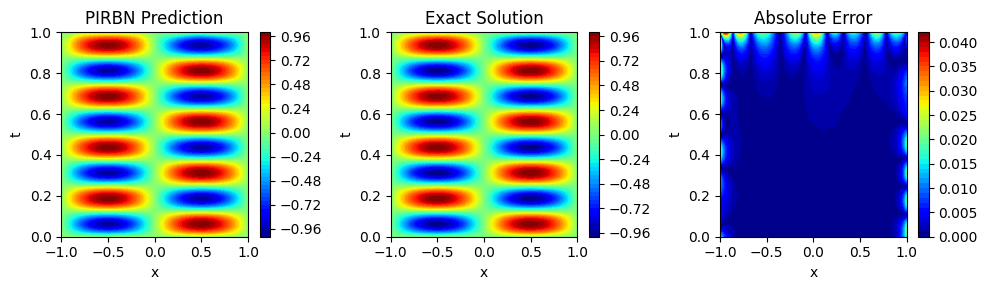

Relative L2 error: 7.87e-03


In [ ]:
N_eval = 200
x_eval = torch.linspace(-1, 1, N_eval, dtype=torch.float64).to(device)
t_eval = torch.linspace(0, 1, N_eval, dtype=torch.float64).to(device)
X_eval, T_eval = torch.meshgrid(x_eval, t_eval, indexing='ij')
XT_eval = torch.stack([X_eval.flatten(), T_eval.flatten()], dim=1)

with torch.no_grad():
    u_pred = model(XT_eval).view(N_eval, N_eval).cpu().numpy()
    u_exact = analytical(X_eval, T_eval).cpu().numpy()

# Plot
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.contourf(X_eval.cpu(), T_eval.cpu(), u_pred, levels=50, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('PIRBN Prediction')

plt.subplot(1, 3, 2)
plt.contourf(X_eval.cpu(), T_eval.cpu(), u_exact, levels=50, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')

plt.subplot(1, 3, 3)
plt.contourf(X_eval.cpu(), T_eval.cpu(), np.abs(u_pred - u_exact), levels=50, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')

plt.tight_layout()
plt.show()

l2_error = np.sqrt(np.mean((u_pred - u_exact)**2)) / np.sqrt(np.mean(u_exact**2))
print(f"Relative L2 error: {l2_error:.2e}")
